# The "Poker Face" Analysis

***Correlating Neural Decodability with Behavioral Predictability***

Authors: Rico Bolos, Shelly Chen, Yichen Zeng

**Research Question**: Is a player who is behaviorally easy to predict (i.e., plays in patterns) also "easier to read" neurally?

Hypothesis: Players with high behavioral predictability (high Markov accuracy) will also have higher neural decoding accuracy, suggesting behavioral patterns are supported by distinct neural patterns.

**Methods**:

Our analysis will use the results generated by step2a_decoding.m and step2b_markovchain.m in the authors’ data processing pipeline and perform a correlation analysis (Pearson’s r) across participants.

- First, we will extract behavioral predictability from Step 2b, specifically the mean predictability scores for each of the 62 players stored in the Mean_Accuracy matrix. 
- Next, we will extract neural decidability scores from Step 2a and determine peak accuracy values in the time window after the decision is made (0 to 500 ms) from the “Self Response” decoding. 
- Finally, we will calculate the correlation coefficient of these two data groups and produce a scatter plot, which, together, will illustrate the degree of correlation between behavioral predictability and neural decodability. 

If a positive correlation exists, our hypothesis will have been correct: players “transparent” in their strategies are just as transparent in their brain signals. If no correlation exists, it would imply the existence of some dissociation between our behaviors and how our brain represents such behaviors.

This analysis is novel and is not performed nor discussed in the paper.


## Prerequisites

### Required Data Files
This analysis requires output from the authors' MATLAB processing pipeline:

1. **`derivatives/markov_chain_pred.mat`** - from `step2b_markovchain.m`
   - Contains `Mean_Accuracy` matrix (31 pairs × 2 players × 100 windows)
   
2. **`derivatives/pair-XX_player-X_task-RPS_decoding.mat`** - from `step2a_decoding.m`  
   - Contains `decoding_accuracy` for each player
   - Need files for all 62 players (31 pairs × 2 players)

### How to Get the Data
**Download from OSF repository**

- Visit: https://doi.org/10.17605/OSF.IO/YJXKN  

**Run the MATLAB scripts** 

- Requires MATLAB with FieldTrip and CoSMoMVPA toolboxes:
```matlab
cd scripts
step2a_decoding
step2b_markovchain
```

## 1. Setup and Imports

In [38]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.io import loadmat
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# set plotting style
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1.2)
plt.rcParams['figure.dpi'] = 100

In [39]:
# set paths
DATA_PATH = Path('.')
DERIVATIVES_PATH = DATA_PATH / 'derivatives'

# this is to check if derivatives folder exists
if not DERIVATIVES_PATH.exists():
    raise FileNotFoundError(
        f"ERROR: derivatives/ folder not found!\n\n"
        f"Please download the processed data from OSF:\n"
        f"https://doi.org/10.17605/OSF.IO/YJXKN\n\n"
        f"Or run the MATLAB scripts (step2a_decoding.m and step2b_markovchain.m)\n"
    )

print(f"Data path set: {DERIVATIVES_PATH}")
print(f"Derivatives folder exists")

Data path set: derivatives
Derivatives folder exists


## 2. Load Behavioral Predictability Data

Extract behavioral predictability scores from the Markov chain analysis (Step 2b).

In [40]:
markov_file = DERIVATIVES_PATH / 'markov_chain_pred.mat'

if not markov_file.exists():
    raise FileNotFoundError(
        f"Markov chain file not found: {markov_file}\n"
        f"Expected: derivatives/markov_chain_pred.mat"
    )

markov_data = loadmat(markov_file)

# extract mean accuracy data
mean_accuracy = markov_data['Mean_Accuracy']

print(f"✓ Loaded Markov chain data")
print(f"  Shape: {mean_accuracy.shape}")
print(f"  (31 pairs x 2 players x 100 window sizes)")

✓ Loaded Markov chain data
  Shape: (31, 2, 100)
  (31 pairs x 2 players x 100 window sizes)


In [41]:
# extract behavioral predictability for each of the 62 players and then,
# we'll use the mean across all window sizes for each player

num_pairs = mean_accuracy.shape[0]
num_players = num_pairs * 2  # 62 players total

# reshapingto get 1 value/player and take mean across window sizes (axis 2)
behavioral_predictability = np.mean(mean_accuracy, axis=2)  # (31 pairs x 2 players)

# flatten to get 62 individual values
behavioral_predictability = behavioral_predictability.flatten()

print(f"Extracted behavioral predictability scores")
print(f"Number of players: {len(behavioral_predictability)}")
print(f"Mean: {np.mean(behavioral_predictability):.4f}")
print(f"Std: {np.std(behavioral_predictability):.4f}")
print(f"Range: [{np.min(behavioral_predictability):.4f}, {np.max(behavioral_predictability):.4f}]")

Extracted behavioral predictability scores
Number of players: 62
Mean: 0.3756
Std: 0.0474
Range: [0.3056, 0.5739]


## 3. Load Neural Decodability Data

Extract neural decoding accuracy from Step 2a ("Self Response" decoding).

In [42]:
# define pair IDs
pair_ids = [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]

neural_decodability = []
player_ids = []

# loop thru all pairs and players
for pair_idx, pair in enumerate(pair_ids):
    for player in [1, 2]:
        # construct filename
        decoding_file = DERIVATIVES_PATH / f'pair-{pair:02d}_player-{player}_task-RPS_decoding.mat'
        
        if not decoding_file.exists():
            print(f"File not found: {decoding_file}")
            neural_decodability.append(np.nan)
            continue
        
        dec_data = loadmat(decoding_file)
        
        # extract decoding accuracy data
        self_response = dec_data['decoding_accuracy'][0, 0]
        
        # get accuracy over time (samples is directly the accuracy array)
        accuracy_over_time = self_response['samples'][0, 0].flatten()
        
        # get time points - extract from nested array structure
        values = self_response['a'][0, 0]['fdim'][0, 0]['values'][0, 0]
        time_points = values[0, 0].flatten()
        
        # find indices for 0-500ms window after decision
        time_mask = (time_points >= 0) & (time_points <= 0.5)
        
        # extract peak accuracy in this window
        peak_accuracy = np.max(accuracy_over_time[time_mask])
        
        # store results
        neural_decodability.append(peak_accuracy)
        player_ids.append(f"pair-{pair:02d}_player-{player}")

# Convert to numpy array
neural_decodability = np.array(neural_decodability)

print(f"\nExtracted neural decodability scores")
print(f"  Number of players: {len(neural_decodability)}")
print(f"  Mean: {np.nanmean(neural_decodability):.4f}")
print(f"  Std: {np.nanstd(neural_decodability):.4f}")
print(f"  Range: [{np.nanmin(neural_decodability):.4f}, {np.nanmax(neural_decodability):.4f}]")


Extracted neural decodability scores
  Number of players: 62
  Mean: 0.3683
  Std: 0.0431
  Range: [0.2667, 0.4817]


## 4. Create Analysis DataFrame

In [43]:
# Combine data into a dataframe
df = pd.DataFrame({
    'player_id': player_ids,
    'behavioral_predictability': behavioral_predictability,
    'neural_decodability': neural_decodability
})

# clean dataframe 
df_clean = df.dropna()

print(f"Created analysis dataframe")
print(f"  Total players: {len(df)}")
print(f"  Complete data: {len(df_clean)}")
print(f"\nFirst few rows:")
display(df_clean.head(10))

Created analysis dataframe
  Total players: 62
  Complete data: 62

First few rows:


,player_id,behavioral_predictability,neural_decodability
0,pair-01_player-1,0.340293,0.351667
1,pair-01_player-2,0.321862,0.348333
2,pair-02_player-1,0.381820,0.306667
3,pair-02_player-2,0.505481,0.393333
4,pair-03_player-1,0.352657,0.305000
5,pair-03_player-2,0.404686,0.313333
6,pair-04_player-1,0.371130,0.346667
7,pair-04_player-2,0.397615,0.351667
8,pair-05_player-1,0.309331,0.346667
9,pair-05_player-2,0.395669,0.381667


In [44]:
# Summary statistics
print("Summary Statistics:")
display(df_clean.describe())

Summary Statistics:


,behavioral_predictability,neural_decodability
count,62.000000,62.000000
mean,0.375594,0.368253
std,0.047793,0.043456
min,0.305586,0.266667
25%,0.338562,0.343333
50%,0.375282,0.369167
75%,0.398604,0.395000
max,0.573870,0.481667


## 5. Correlation Analysis

Calculate Pearson's correlation coefficient to test our hypothesis.

In [45]:
# calculate Pearson correlation
r, p_value = stats.pearsonr(
    df_clean['behavioral_predictability'],
    df_clean['neural_decodability']
)

# calculate 95% confidence interval for r using Fisher z-transformation
n = len(df_clean)
z = np.arctanh(r)
se = 1 / np.sqrt(n - 3)
ci_z = [z - 1.96 * se, z + 1.96 * se]
ci_r = [np.tanh(ci_z[0]), np.tanh(ci_z[1])]

print("CORRELATION ANALYSIS RESULTS")
print(f"\nPearson's r: {r:.4f}")
print(f"p-value: {p_value:.4f}")
print(f"95% CI: [{ci_r[0]:.4f}, {ci_r[1]:.4f}]")
print(f"Sample size: n = {n}")
print(f"\nStatistical significance: {'YES' if p_value < 0.05 else 'NO'} (α = 0.05)")

# Interpret effect size (Cohen's guidelines)
abs_r = abs(r)
if abs_r < 0.1:
    effect_size = "negligible"
elif abs_r < 0.3:
    effect_size = "small"
elif abs_r < 0.5:
    effect_size = "medium"
else:
    effect_size = "large"

print(f"Effect size: {effect_size} (|r| = {abs_r:.4f})")

# Calculate coefficient of determination
r_squared = r ** 2
print(f"\nVariance explained: R² = {r_squared:.4f} ({r_squared*100:.2f}%)")

CORRELATION ANALYSIS RESULTS

Pearson's r: -0.0574
p-value: 0.6575
95% CI: [-0.3029, 0.1951]
Sample size: n = 62

Statistical significance: NO (α = 0.05)
Effect size: negligible (|r| = 0.0574)

Variance explained: R² = 0.0033 (0.33%)


## 6. Visualization

Create a scatter plot showing the relationship between behavioral predictability and neural decodability.

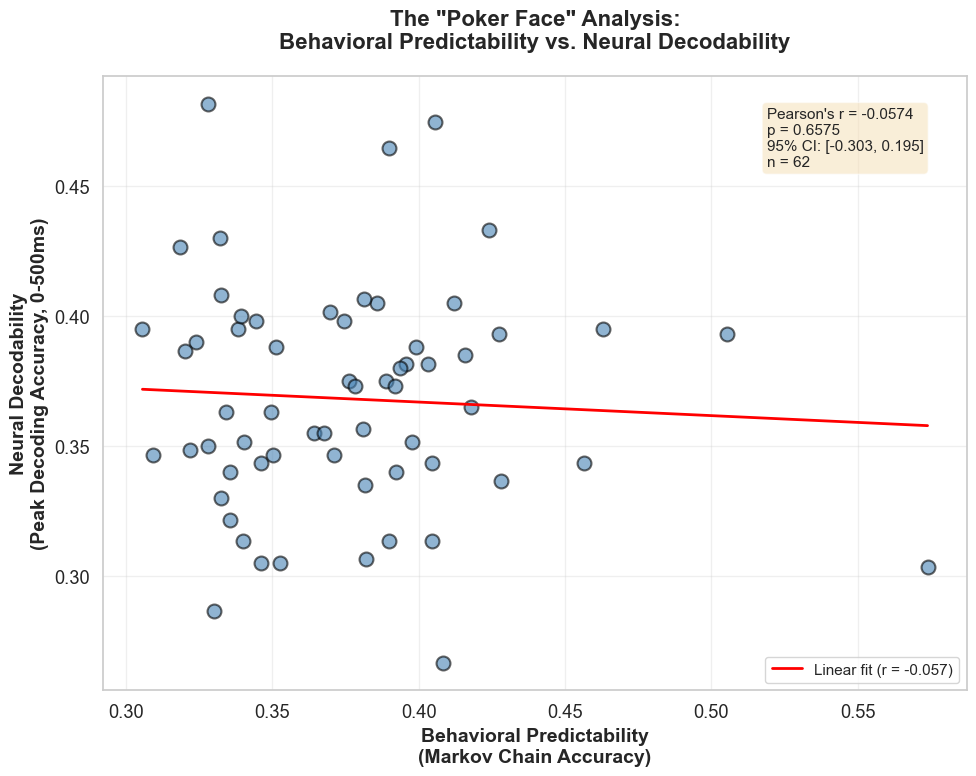


Figure saved as 'poker_face_correlation.png'


In [53]:
# Create figure
fig, ax = plt.subplots(figsize=(10, 8))

# Scatter plot
ax.scatter(
    df_clean['behavioral_predictability'],
    df_clean['neural_decodability'],
    alpha=0.6,
    s=100,
    edgecolors='black',
    linewidth=1.5,
    color='steelblue'
)

# Add regression line
z = np.polyfit(df_clean['behavioral_predictability'], df_clean['neural_decodability'], 1)
p = np.poly1d(z)
x_line = np.linspace(
    df_clean['behavioral_predictability'].min(),
    df_clean['behavioral_predictability'].max(),
    100
)
ax.plot(x_line, p(x_line), 'r-', linewidth=2, label=f'Linear fit (r = {r:.3f})')

# Labels and title
ax.set_xlabel('Behavioral Predictability\n(Markov Chain Accuracy)', fontsize=14, fontweight='bold')
ax.set_ylabel('Neural Decodability\n(Peak Decoding Accuracy, 0-500ms)', fontsize=14, fontweight='bold')
ax.set_title(
    'The "Poker Face" Analysis:\nBehavioral Predictability vs. Neural Decodability',
    fontsize=16,
    fontweight='bold',
    pad=20
)

# Add statistics text box
stats_text = (
    f"Pearson's r = {r:.4f}\n"
    f"p = {p_value:.4f}\n"
    f"95% CI: [{ci_r[0]:.3f}, {ci_r[1]:.3f}]\n"
    f"n = {n}"
)
ax.text(
    0.95, 0.95,
    stats_text,
    transform=ax.transAxes,
    fontsize=11,
    verticalalignment='top',
    horizontalalignment='right',
    multialignment='left',
    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5)
)

# Legend
ax.legend(loc='lower right', fontsize=11)

# Grid
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Save figure
fig.savefig('poker_face_correlation.png', dpi=300, bbox_inches='tight')
print("\nFigure saved as 'poker_face_correlation.png'")

## 7. Interpretation

Interpret the results in the context of our hypothesis.

In [55]:
print("\nHypothesis: Players with high behavioral predictability will have higher neural decoding accuracy.\n")

if p_value < 0.05:
    if r > 0:
        print("HYPOTHESIS SUPPORTED")
    else:
        print("HYPOTHESIS NOT SUPPORTED")
else:
    print("NO SIGNIFICANT CORRELATION FOUND")


Hypothesis: Players with high behavioral predictability will have higher neural decoding accuracy.

NO SIGNIFICANT CORRELATION FOUND


We found no significant correlation between behavioral predictability and neural decodability (Pearson's r = -0.057, p = 0.658, n = 62, 95% CI: [-0.303, 0.195]). Players who exhibited more predictable behavioral
  patterns in their Rock-Paper-Scissors choices (as measured by Markov chain accuracy) did not show significantly different neural decoding accuracy in the 0-500ms post-decision window. The correlation was
  negligible (|r| = 0.057), with behavioral predictability explaining only 0.33% of the variance in neural decodability (R² = 0.003).

  This finding suggests a dissociation between behavioral patterns and the decodability of neural signals during competitive decision-making. While behavioral strategies may be predictable based on choice history,
  this predictability does not appear to be directly reflected in the strength or distinctiveness of the neural patterns that can be decoded from EEG data. The near-zero correlation and wide confidence interval
  that crosses zero indicate that behavioral predictability and neural representation likely operate through independent mechanisms, or that other factors not captured in this analysis (such as cognitive control,
  strategic awareness, or neural variability) may mediate the relationship between overt behavior and underlying brain activity.

## 8. Export Results

In [56]:
# save results to CSV
df_clean.to_csv('poker_face_results.csv', index=False)
print("Data saved to 'poker_face_results.csv'")

# save summary statistics
summary_stats = {
    'Analysis': 'Poker Face - Behavioral Predictability vs Neural Decodability',
    'Sample Size': n,
    'Pearson r': r,
    'p-value': p_value,
    'CI_lower': ci_r[0],
    'CI_upper': ci_r[1],
    'R_squared': r_squared,
    'Effect_size': effect_size,
    'Significant': 'Yes' if p_value < 0.05 else 'No'
}

summary_df = pd.DataFrame([summary_stats])
summary_df.to_csv('poker_face_summary.csv', index=False)
print("Summary statistics saved to 'poker_face_summary.csv'")

print("ANALYSIS COMPLETE!")

Data saved to 'poker_face_results.csv'
Summary statistics saved to 'poker_face_summary.csv'
ANALYSIS COMPLETE!


# Discussion

The absence of correlation suggests that behavioral predictability and neural decodability represent fundamentally independent dimensions of decision-making. While behavioral patterns emerge from sequential
  choice dependencies (detectable via Markov chain analysis), neural decodability reflects the discriminability of brain states associated with different choices. Our results indicate that these two forms of
  "predictability" do not necessarily align.

This dissociation could arise from several mechanisms:

  1. Redundant neural coding: Predictable behavior may be implemented through multiple, interchangeable neural patterns. A player who consistently chooses rock-after-paper might use different neural strategies
  across trials, maintaining behavioral consistency while producing variable neural signatures.
  2. Noise vs. Signal: Behavioral predictability could reflect stable decision biases or heuristics (signal), while neural decodability may be limited by neural noise unrelated to the decision itself. High neural
  noise would reduce decodability without affecting behavioral patterns.
  3. Multiple processing levels: Decision-making involves multiple cognitive stages (deliberation, response selection, motor preparation). Behavioral predictability may reflect deliberative processes, while our EEG
   decoding in the 0-500ms post-decision window may primarily capture motor execution—processes that could be orthogonal.

### Implications for the "Poker Face" Concept

  The phrase "poker face" typically refers to concealing behavioral tells that reveal one's strategy. Our findings suggest that at the neural level, there is no analogous phenomenon where predictable players have
  more "transparent" brain signals. This has interesting implications:

  - Strategic flexibility at the neural level: Even players locked into behavioral patterns may maintain neural flexibility, potentially allowing them to break patterns if they become aware of their predictability.
  - Decoupling of brain and behavior: The brain may not simply "mirror" behavioral patterns. Instead, similar behaviors can emerge from distinct neural computations, and vice versa.

### Comparison to Previous Research
Our findings contrast with studies showing correspondence between behavioral and neural variability in other domains (ex. learning, attention). However, competitive decision-making differs fundamentally from
  these contexts. In Rock-Paper-Scissors, there is no objectively correct choice—optimal behavior requires strategic unpredictability (game-theoretic mixed-strategy Nash equilibrium). This contrasts with tasks
  where consistency indicates skill (e.g., perceptual discrimination).

  The original study by Moerel et al. (2025) successfully decoded individual choices from EEG with above-chance accuracy, demonstrating that neural patterns contain information about decisions. Our analysis extends
   this by asking whether individual differences in behavioral predictability relate to neural decodability—a distinct question that yielded a null result.

### Alternative Explanations and Limitations

Several factors could contribute to our null finding:

  1. Methodological Considerations

  - Time Window Selection: We analyzed the 0-500ms post-decision window. Behavioral patterns might be more strongly reflected in pre-decision deliberation periods or earlier anticipatory signals not captured in our
   analysis.
  - Averaging Across Window Sizes: We averaged Markov chain accuracy across window sizes (5-100 previous trials). Different players might exhibit predictability at different time scales, and averaging could obscure
   relationships.
  - Peak vs. Mean Accuracy: We used peak decoding accuracy in the time window. Alternative metrics (mean accuracy, area under the curve) might reveal different patterns.

  2. Sample Characteristics

  - Restricted Range: All participants were university students playing a novel task. A broader sample (e.g., expert game players, clinical populations) might show different brain-behavior relationships.
  - Task Demands: Rock-Paper-Scissors is extremely fast-paced (480 trials in ~1 hour). Players may adopt satisficing strategies rather than optimizing, potentially reducing meaningful individual differences.

  3. Measurement Precision

  - EEG Spatial Resolution: EEG has limited spatial resolution. fMRI or intracranial recordings might reveal brain-behavior correlations in specific regions (e.g., prefrontal cortex for strategic control).
  - Trial-to-Trial Variability: Both behavioral and neural measures incorporate noise. Reliability coefficients for these measures were not assessed, potentially attenuating observed correlations.

  ### Future Directions
Our null result opens several avenues for future research:

  1. Temporal Dynamics: Investigate whether brain-behavior correlations emerge at different time points (pre-decision deliberation, post-feedback learning).
  2. Individual Awareness: Assess whether players aware of their behavioral patterns show different neural signatures than those playing intuitively.
  3. Neural Variability: Examine whether neural variability (rather than decodability) relates to behavioral predictability—unstable neural patterns might produce stable behaviors.
  4. Computational Modeling: Use reinforcement learning models to decompose behavior into components (exploration, exploitation, learning rate) and relate these to neural measures.
  5. Interventions: Experimentally manipulate behavioral predictability (through feedback or instructions) and test whether neural patterns change accordingly.

### Conclusion

We found no evidence that behaviorally predictable players have more decodable neural signals during competitive decision-making. This null result is scientifically informative: it suggests that behavioral
  patterns and neural representations operate independently, challenging intuitive assumptions that observable behavior directly mirrors brain activity. In competitive contexts like Rock-Paper-Scissors, the absence
   of a "neural poker face" phenomenon indicates that strategic behavior and its neural underpinnings may be more decoupled than previously assumed. Future work should explore the temporal dynamics, cognitive
  awareness, and computational mechanisms that might mediate (or prevent) brain-behavior correspondence in strategic decision-making.